In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from pathlib import Path
import re # For extracting player slug from filename

# Plotting style
try:
    plt.style.use('seaborn-whitegrid') # This worked for you
except OSError:
    print("Style 'seaborn-whitegrid' not found, trying 'ggplot'.")
    plt.style.use('ggplot')

sns.set_context("talk")

# --- Configuration ---
SEASONS_STR = "2022_2024" #=
BASE_PROCESSED_DATA_DIR = Path("../data/new/processed_data/")

# --- Discover Player Files ---
processed_files_pattern = f"*_stats_sentiment_{SEASONS_STR}.csv"
player_files_info = []

for f_path in BASE_PROCESSED_DATA_DIR.glob(processed_files_pattern):
    filename = f_path.name
    # Extract player slug: assumes format like "player_slug_stats_sentiment_2022_2024.csv"
    match = re.match(rf"(.+)_stats_sentiment_{SEASONS_STR}\.csv", filename)
    if match:
        player_slug = match.group(1)
        player_name_display = player_slug.replace('_', ' ').title()
        player_files_info.append({
            "slug": player_slug,
            "display_name": player_name_display,
            "file_path": f_path
        })
    else:
        # Check for the '_plus_' variant if the primary pattern fails
        match_plus = re.match(rf"(.+)_stats_plus_sentiment_{SEASONS_STR}\.csv", filename)
        if match_plus:
            player_slug = match_plus.group(1)
            player_name_display = player_slug.replace('_', ' ').title()
            player_files_info.append({
                "slug": player_slug,
                "display_name": player_name_display,
                "file_path": f_path
            })
        # Check for the '_fullsnap_' variant
        match_fullsnap = re.match(rf"(.+)_stats_plus_sentiment_fullsnap_{SEASONS_STR}\.csv", filename)
        if match_fullsnap:
            player_slug = match_fullsnap.group(1)
            player_name_display = player_slug.replace('_', ' ').title()
            player_files_info.append({
                "slug": player_slug,
                "display_name": player_name_display,
                "file_path": f_path
            })


if not player_files_info:
    print(f"❌ No processed player files found in {BASE_PROCESSED_DATA_DIR} matching the pattern '{processed_files_pattern}' or similar variations.")
    print("Please ensure 'process_all_players.py' has run and generated files like 'playername_stats_sentiment_2022_2024.csv'")
else:
    print(f"Found {len(player_files_info)} players to process:")
    for p_info in player_files_info:
        print(f"  - {p_info['display_name']} (File: {p_info['file_path'].name})")

Found 8 players to process:
  - Anthony Edwards (File: anthony_edwards_stats_sentiment_2022_2024.csv)
  - Donovan Mitchell (File: donovan_mitchell_stats_sentiment_2022_2024.csv)
  - Giannis Antetokounmpo (File: giannis_antetokounmpo_stats_sentiment_2022_2024.csv)
  - Jalen Brunson (File: jalen_brunson_stats_sentiment_2022_2024.csv)
  - Lebron James (File: lebron_james_stats_sentiment_2022_2024.csv)
  - Luka Doncic (File: luka_doncic_stats_sentiment_2022_2024.csv)
  - Shai Gilgeous-Alexander (File: shai_gilgeous-alexander_stats_sentiment_2022_2024.csv)
  - Stephen Curry (File: stephen_curry_stats_sentiment_2022_2024.csv)


In [4]:
# High-level Goal: Unsupervised exploration of NBA player performance and associated Reddit sentiment.
# This notebook will iterate through available processed player data, performing
# data loading, preprocessing, visualization, and correlation analysis.
print("Project Goal: Automated analysis for multiple players.")

Project Goal: Automated analysis for multiple players.


In [5]:
def load_and_preprocess_data(file_path, player_name_display):
    """Loads and preprocesses the combined stats and sentiment data for a player."""
    if not file_path.exists():
        print(f"❌ ERROR: Data file not found at {file_path} for {player_name_display}")
        return None

    print(f"\n--- Loading data for {player_name_display} from {file_path.name} ---")
    df = pd.read_csv(file_path)
    print(f"Initial rows loaded: {len(df)}")

    if 'game_date' not in df.columns:
        # Fallback if 'game_date' was not correctly named/saved by previous script, try 'GAME_DATE'
        if 'GAME_DATE' in df.columns:
            print("Using 'GAME_DATE' and converting to datetime.")
            df['game_date'] = pd.to_datetime(df['GAME_DATE'], errors='coerce')
        else:
            print(f"❌ ERROR: Neither 'game_date' nor 'GAME_DATE' column found for {player_name_display}.")
            return None
    else:
        df['game_date'] = pd.to_datetime(df['game_date'], errors='coerce')
    
    df.dropna(subset=['game_date'], inplace=True)

    if 'WL' in df.columns:
        df['WIN'] = df['WL'].apply(lambda x: 1 if x == 'W' else 0 if x == 'L' else np.nan)
        df.dropna(subset=['WIN'], inplace=True)
        df['WIN'] = df['WIN'].astype(int)
    else:
        print(f"⚠️ WL column not found for {player_name_display}. Cannot create WIN feature.")
        df['WIN'] = np.nan # Add WIN column as NaN if WL is missing

    print(f"Rows before filtering on post_count: {len(df)}")
    if 'post_count' in df.columns:
        df_filtered = df[df['post_count'] > 0].copy()
        print(f"Rows after filtering for post_count > 0: {len(df_filtered)}")
        if len(df_filtered) == 0:
            print(f"⚠️ No games found with post_count > 0 for {player_name_display}. Sentiment analysis will be limited.")
            # Return the original df if no posts, so at least stats can be analyzed if desired (optional)
            # For this project, we require sentiment, so we'll return None if no sentiment games
            return None 
        print(f"Filtered data to {len(df_filtered)} games with sentiment (post_count > 0).")
    else:
        print(f"❌ ERROR: 'post_count' column not found for {player_name_display}. Cannot filter for games with sentiment.")
        return None

        # --- Derived sentiment feature -------------------------------
    if {'mean_sentiment', 'post_count'}.issubset(df_filtered.columns):
        df_filtered['sent_intensity'] = (
            df_filtered['mean_sentiment'] * df_filtered['post_count']
        )
    else:
        df_filtered['sent_intensity'] = np.nan
        
    return df_filtered

print("Helper function 'load_and_preprocess_data' defined.")

Helper function 'load_and_preprocess_data' defined.


In [1]:
if not player_files_info:
    print("No player files were found to process. Halting execution.")
else:
    for player_info in player_files_info:
        PLAYER_SLUG = player_info["slug"]
        PLAYER_NAME_DISPLAY = player_info["display_name"]
        input_file_path = player_info["file_path"]

        print(f"\n\n{'='*20} PROCESSING: {PLAYER_NAME_DISPLAY} {'='*20}")
        
        df_player = load_and_preprocess_data(input_file_path, PLAYER_NAME_DISPLAY)

        if df_player is None or df_player.empty:
            print(f"--- Skipping further analysis for {PLAYER_NAME_DISPLAY} due to missing data or no games with sentiment ---")
            continue

        # --- 4.1: Univariate Distributions ---
        print(f"\n--- Univariate Distributions for {PLAYER_NAME_DISPLAY} ---")
        performance_features_to_plot = ['PTS', 'AST', 'REB', 'PLUS_MINUS', 'FG_PCT']
        # Check if 'neg_share' exists, it was added in the process_all_players.py
        sentiment_features_to_plot = ['mean_sentiment', 'pos_share', 
                                      'neg_share' if 'neg_share' in df_player.columns else 'min_sentiment', 
                                      'post_count', 'avg_delta_days']
        
        plt.figure(figsize=(18, 10))
        plot_idx = 1
        for col_list, sup_title_part in [(performance_features_to_plot, "Performance"), (sentiment_features_to_plot, "Sentiment Metrics")]:
            for col in col_list:
                if col in df_player.columns and not df_player[col].isnull().all():
                    plt.subplot(2, max(len(performance_features_to_plot), len(sentiment_features_to_plot)), plot_idx)
                    sns.histplot(df_player[col].dropna(), kde=True, bins=15) # dropna for individual columns
                    plt.title(f'Distribution of {col}')
                    plt.xlabel(col)
                    plt.ylabel('Frequency')
                    plot_idx +=1
                else:
                    print(f"  Skipping histogram for missing/empty column: {col}")
        plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
        plt.suptitle(f'Univariate Distributions for {PLAYER_NAME_DISPLAY}', y=1.00, fontsize=16)
        plt.show()

        # --- 4.2: Correlation Analysis ---
        print(f"\n--- Correlation Analysis for {PLAYER_NAME_DISPLAY} ---")
        numerical_stats_cols = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'WIN', 'MIN']
        numerical_sentiment_cols = ['mean_sentiment', 'min_sentiment', 'max_sentiment', 'pos_share', 
                                    'neg_share' if 'neg_share' in df_player.columns else None, 
                                    'post_count', 'avg_delta_days', 'min_delta_days', 'max_delta_days']
        numerical_sentiment_cols = [col for col in numerical_sentiment_cols if col is not None] # Remove None if neg_share isn't there

        correlation_features = [col for col in numerical_stats_cols if col in df_player.columns and pd.api.types.is_numeric_dtype(df_player[col])] + \
                               [col for col in numerical_sentiment_cols if col in df_player.columns and pd.api.types.is_numeric_dtype(df_player[col])]
        
        df_corr = df_player[list(set(correlation_features))].copy() # Use set to ensure unique cols
        
        for col in df_corr.columns: # Coerce and drop NaNs carefully
            df_corr[col] = pd.to_numeric(df_corr[col], errors='coerce')
        df_corr.dropna(inplace=True)

        if len(df_corr) > 1 and len(df_corr.columns) > 1:
            correlation_matrix = df_corr.corr()
            plt.figure(figsize=(18, 15))
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 7})
            plt.title(f'Correlation Matrix for {PLAYER_NAME_DISPLAY}', fontsize=16)
            plt.xticks(rotation=45, ha='right', fontsize=8)
            plt.yticks(rotation=0, fontsize=8)
            plt.tight_layout()
            plt.show()
        else:
            print("  ⚠️ Not enough data or columns for correlation matrix.")
#---------------------------------------------------------------------------
        # --- 4.3B: Unsupervised Clustering (PCA + K‑means) ---------
        print(f"\n--- Unsupervised Clustering for {PLAYER_NAME_DISPLAY} ---")

        cluster_features = [
            'PTS', 'AST', 'REB', 'PLUS_MINUS',
            'mean_sentiment', 'sent_intensity'
        ]
        cluster_features = [c for c in cluster_features if c in df_player.columns]

        # 1) scale ---------------------------------------------------
        X = df_player[cluster_features].fillna(0)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # 2) dimensionality reduction --------------------------------
        pca = PCA(n_components=2, random_state=42)
        X_pca = pca.fit_transform(X_scaled)
        print("   • PCA two‑component variance:",
              round(pca.explained_variance_ratio_.sum(), 3))

        # 3) elbow plot (quick) --------------------------------------
        inertias = []
        for k in range(1, 8):
            inertias.append(
                KMeans(n_clusters=k, n_init=10, random_state=42)
                .fit(X_scaled).inertia_
            )
        plt.figure(figsize=(4, 3))
        plt.plot(range(1, 8), inertias, marker='o')
        plt.title('Elbow for K‑means'); plt.xlabel('k'); plt.ylabel('Inertia')
        plt.show()

        # 4) fit K‑means (k=3 by default) ----------------------------
        k = 3
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        df_player['cluster'] = kmeans.fit_predict(X_scaled)

        # 5) PCA scatter ---------------------------------------------
        plt.figure(figsize=(7, 6))
        sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                        hue=df_player['cluster'], palette='Set2', s=80)
        plt.title(f'PCA space – {PLAYER_NAME_DISPLAY}')
        plt.xlabel('PC1'); plt.ylabel('PC2')
        plt.legend(title='Cluster')
        plt.show()

        # 6) cluster profile table -----------------------------------
        profile_cols = cluster_features + (['WIN'] if 'WIN' in df_player.columns else [])
        print("Cluster medians:")
        display(
            df_player.groupby('cluster')[profile_cols]
                     .median()
                     .round(2)
        )












#-------------------------------------------------------------------------------
        # --- 4.3: Bivariate Scatter Plots ---
        print(f"\n--- Bivariate Scatter Plots for {PLAYER_NAME_DISPLAY} ---")
        key_relationships = [
            ('PTS', 'mean_sentiment'), ('PLUS_MINUS', 'mean_sentiment'),
            ('PTS', 'post_count'), ('WIN', 'mean_sentiment'),
            ('FG_PCT', 'mean_sentiment'), ('mean_sentiment', 'avg_delta_days')
        ]
        plt.figure(figsize=(20, 10)) # Adjusted size for 2 rows if needed
        plot_idx = 1
        for x_col, y_col in key_relationships:
            if x_col in df_player.columns and y_col in df_player.columns:
                plt.subplot(2, 3, plot_idx)
                if x_col == 'WIN' and not df_player[x_col].isnull().all():
                    sns.boxplot(x=df_player[x_col].astype(int), y=df_player[y_col].dropna(), palette={0: 'red', 1: 'green'})
                    plt.xticks([0,1], ['Loss', 'Win'])
                elif not df_player[x_col].isnull().all() and not df_player[y_col].isnull().all():
                    sns.scatterplot(data=df_player, x=x_col, y=y_col, hue='WIN' if 'WIN' in df_player.columns else None, 
                                    palette={0: 'red', 1: 'green'} if 'WIN' in df_player.columns else None, alpha=0.7)
                    try: # Add regplot only if there's enough variance
                        sns.regplot(data=df_player, x=x_col, y=y_col, scatter=False, color='blue', line_kws={'linestyle':'--'})
                    except ValueError:
                        print(f"Could not plot regression line for {x_col} vs {y_col} (possibly due to low variance or NaNs).")
                plt.title(f'{x_col} vs. {y_col}')
                plot_idx += 1
            else:
                 print(f"  Skipping bivariate plot: missing {x_col} or {y_col}")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.suptitle(f'Key Bivariate Relationships for {PLAYER_NAME_DISPLAY}', y=1.00, fontsize=18)
        plt.show()

        # --- 4.4: Sentiment by Game Outcome ---
        if 'WIN' in df_player.columns and not df_player['WIN'].isnull().all():
            print(f"\n--- Sentiment Analysis by Game Outcome for {PLAYER_NAME_DISPLAY} ---")
            plt.figure(figsize=(18, 6))
            sentiment_metrics_for_outcome = ['mean_sentiment', 'pos_share', 
                                             'neg_share' if 'neg_share' in df_player.columns else 'min_sentiment', 
                                             'post_count']
            plot_idx = 1
            for metric in sentiment_metrics_for_outcome:
                if metric in df_player.columns and not df_player[metric].isnull().all():
                    plt.subplot(1, len(sentiment_metrics_for_outcome), plot_idx)
                    sns.boxplot(x='WIN', y=metric, data=df_player, palette={0: 'salmon', 1: 'lightgreen'})
                    plt.title(f'{metric} by Outcome')
                    plt.xticks([0, 1], ['Loss', 'Win'])
                    plt.xlabel('Game Outcome')
                    plt.ylabel(metric.replace('_', ' ').title())
                    plot_idx +=1
                else:
                    print(f"  Skipping outcome plot for missing/empty column: {metric}")
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.suptitle(f'Sentiment Metrics by Game Outcome for {PLAYER_NAME_DISPLAY}', y=1.00, fontsize=16)
            plt.show()
        else:
            print(f"  Skipping sentiment by game outcome for {PLAYER_NAME_DISPLAY} (WIN column missing or all NaN).")
            
        # Optional: Add a small delay or clear plots if running for many players to manage memory/display
        # import time
        # time.sleep(1) 
        # from IPython.display import clear_output
        # clear_output(wait=True)
        
        print(f"\n--- Finished processing {PLAYER_NAME_DISPLAY} ---")





NameError: name 'player_files_info' is not defined



🔗  BUILDING COMBINED DATASET FOR ALL PLAYERS ------------------

--- Loading data for Anthony Edwards from anthony_edwards_stats_sentiment_2022_2024.csv ---
Initial rows loaded: 237
Rows before filtering on post_count: 237
Rows after filtering for post_count > 0: 27
Filtered data to 27 games with sentiment (post_count > 0).

--- Loading data for Donovan Mitchell from donovan_mitchell_stats_sentiment_2022_2024.csv ---
Initial rows loaded: 194
Rows before filtering on post_count: 194
Rows after filtering for post_count > 0: 24
Filtered data to 24 games with sentiment (post_count > 0).

--- Loading data for Giannis Antetokounmpo from giannis_antetokounmpo_stats_sentiment_2022_2024.csv ---
Initial rows loaded: 203
Rows before filtering on post_count: 203
Rows after filtering for post_count > 0: 24
Filtered data to 24 games with sentiment (post_count > 0).

--- Loading data for Jalen Brunson from jalen_brunson_stats_sentiment_2022_2024.csv ---
Initial rows loaded: 210
Rows before filterin

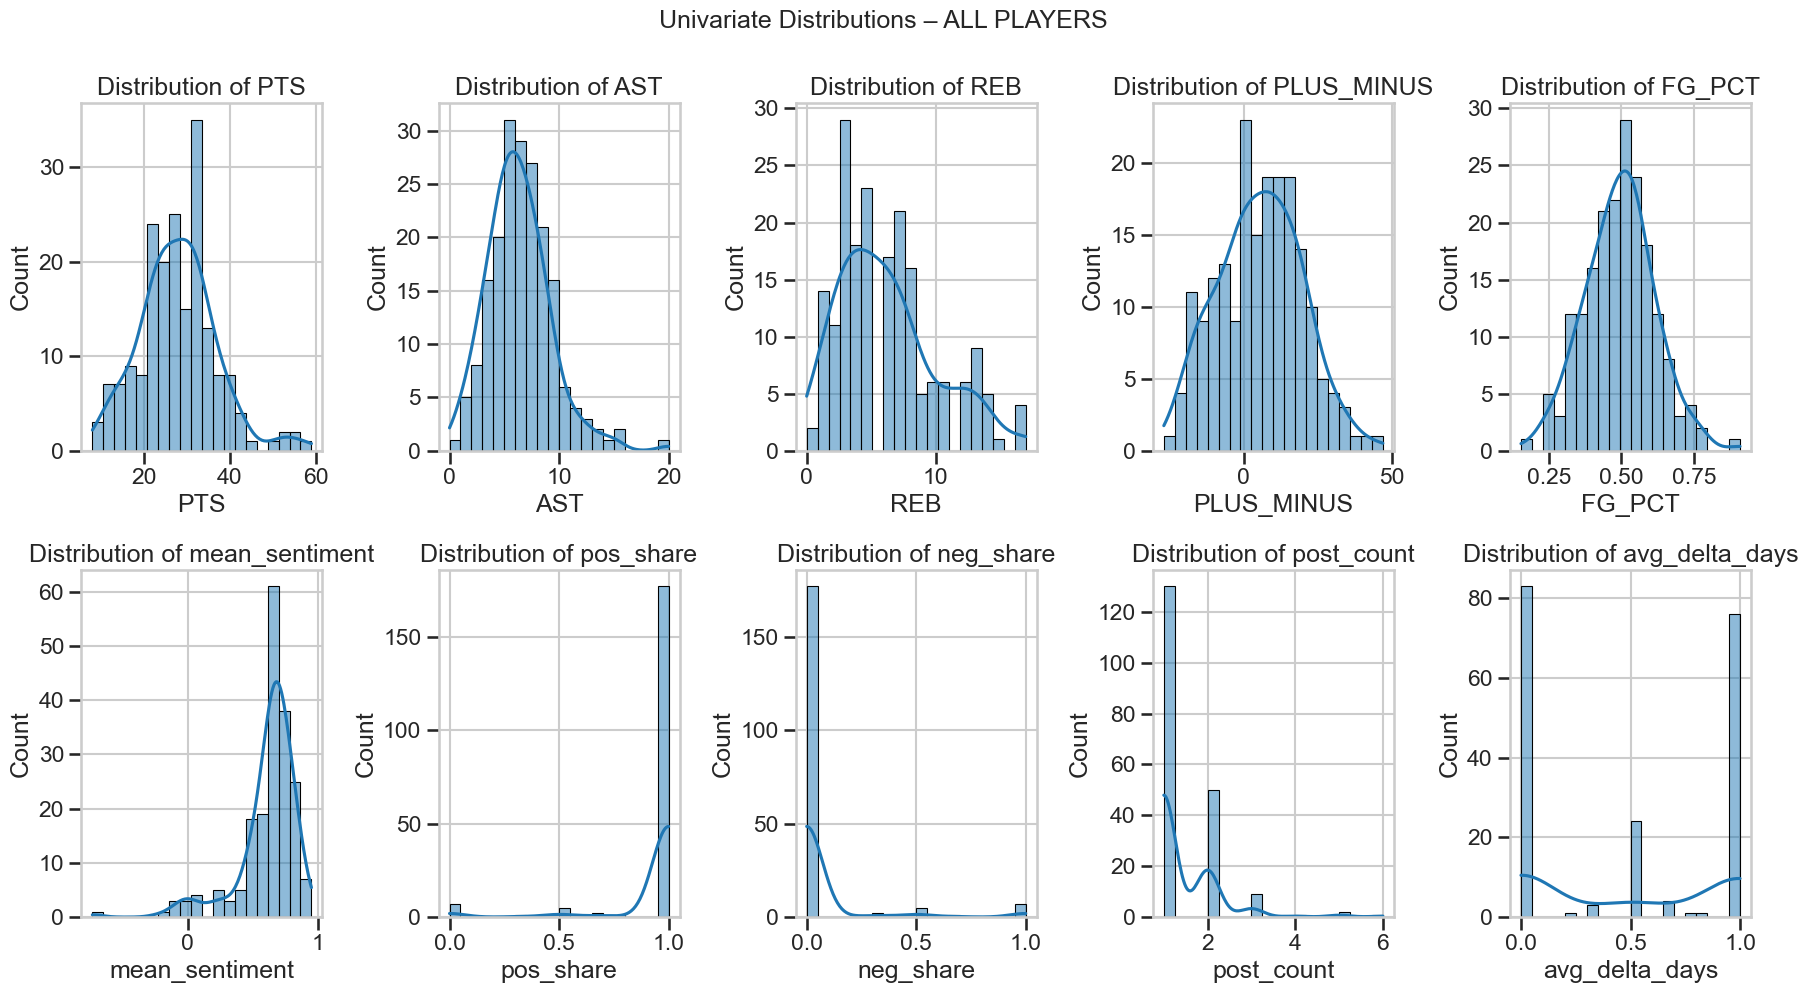


--- COMBINED CORRELATION MATRIX ---


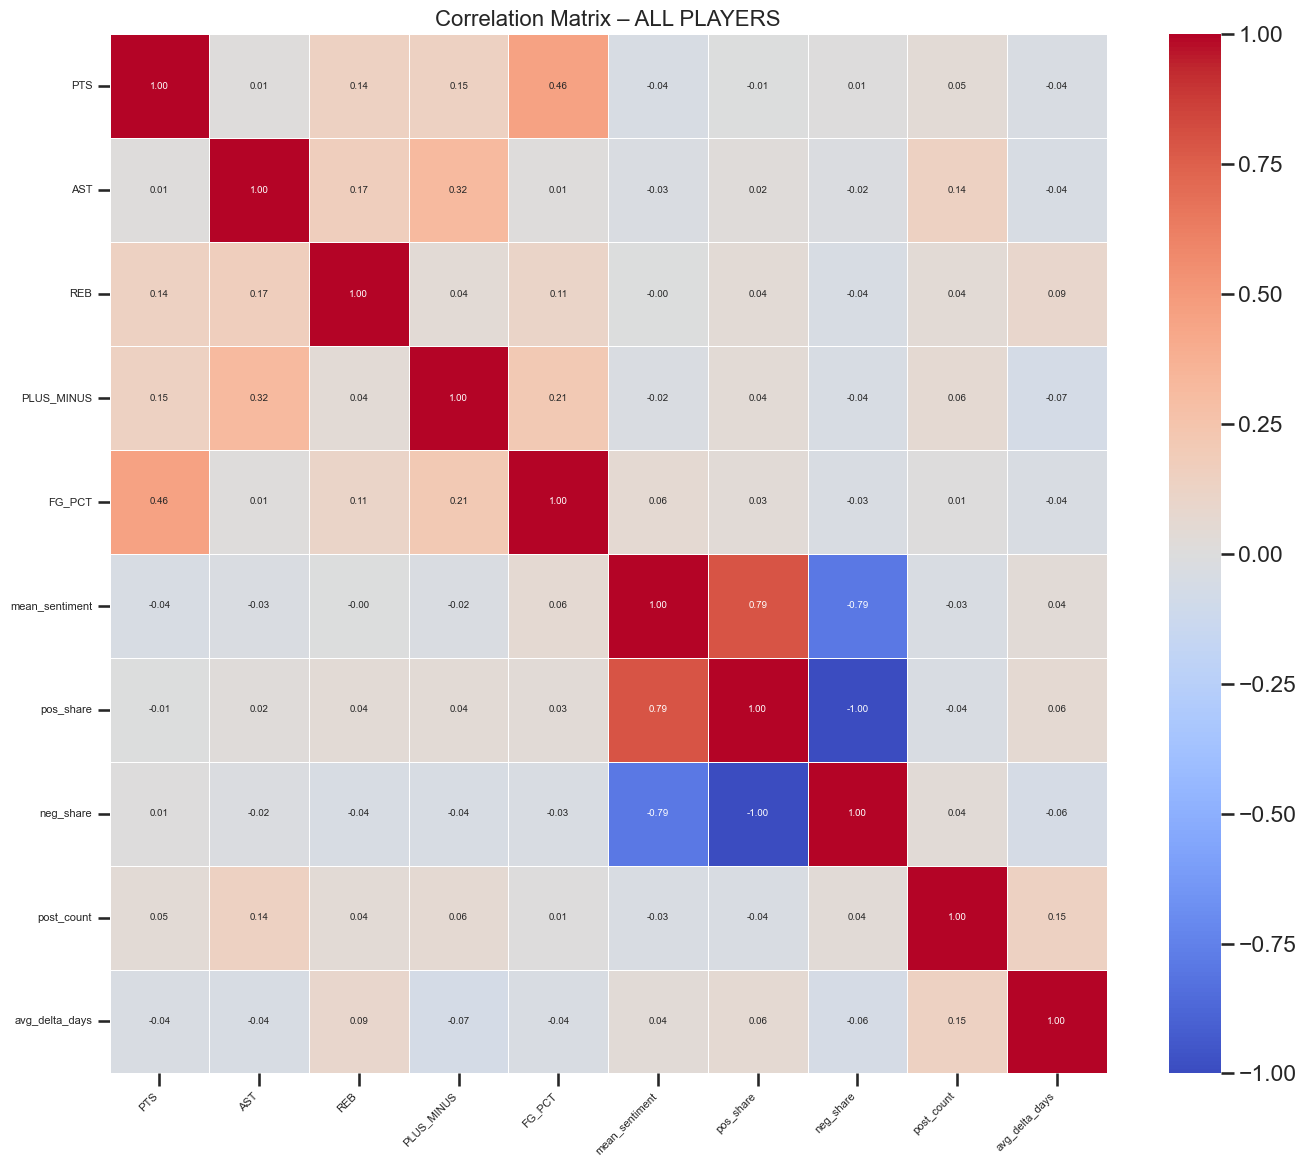


--- COMBINED BIVARIATE RELATIONSHIPS ---


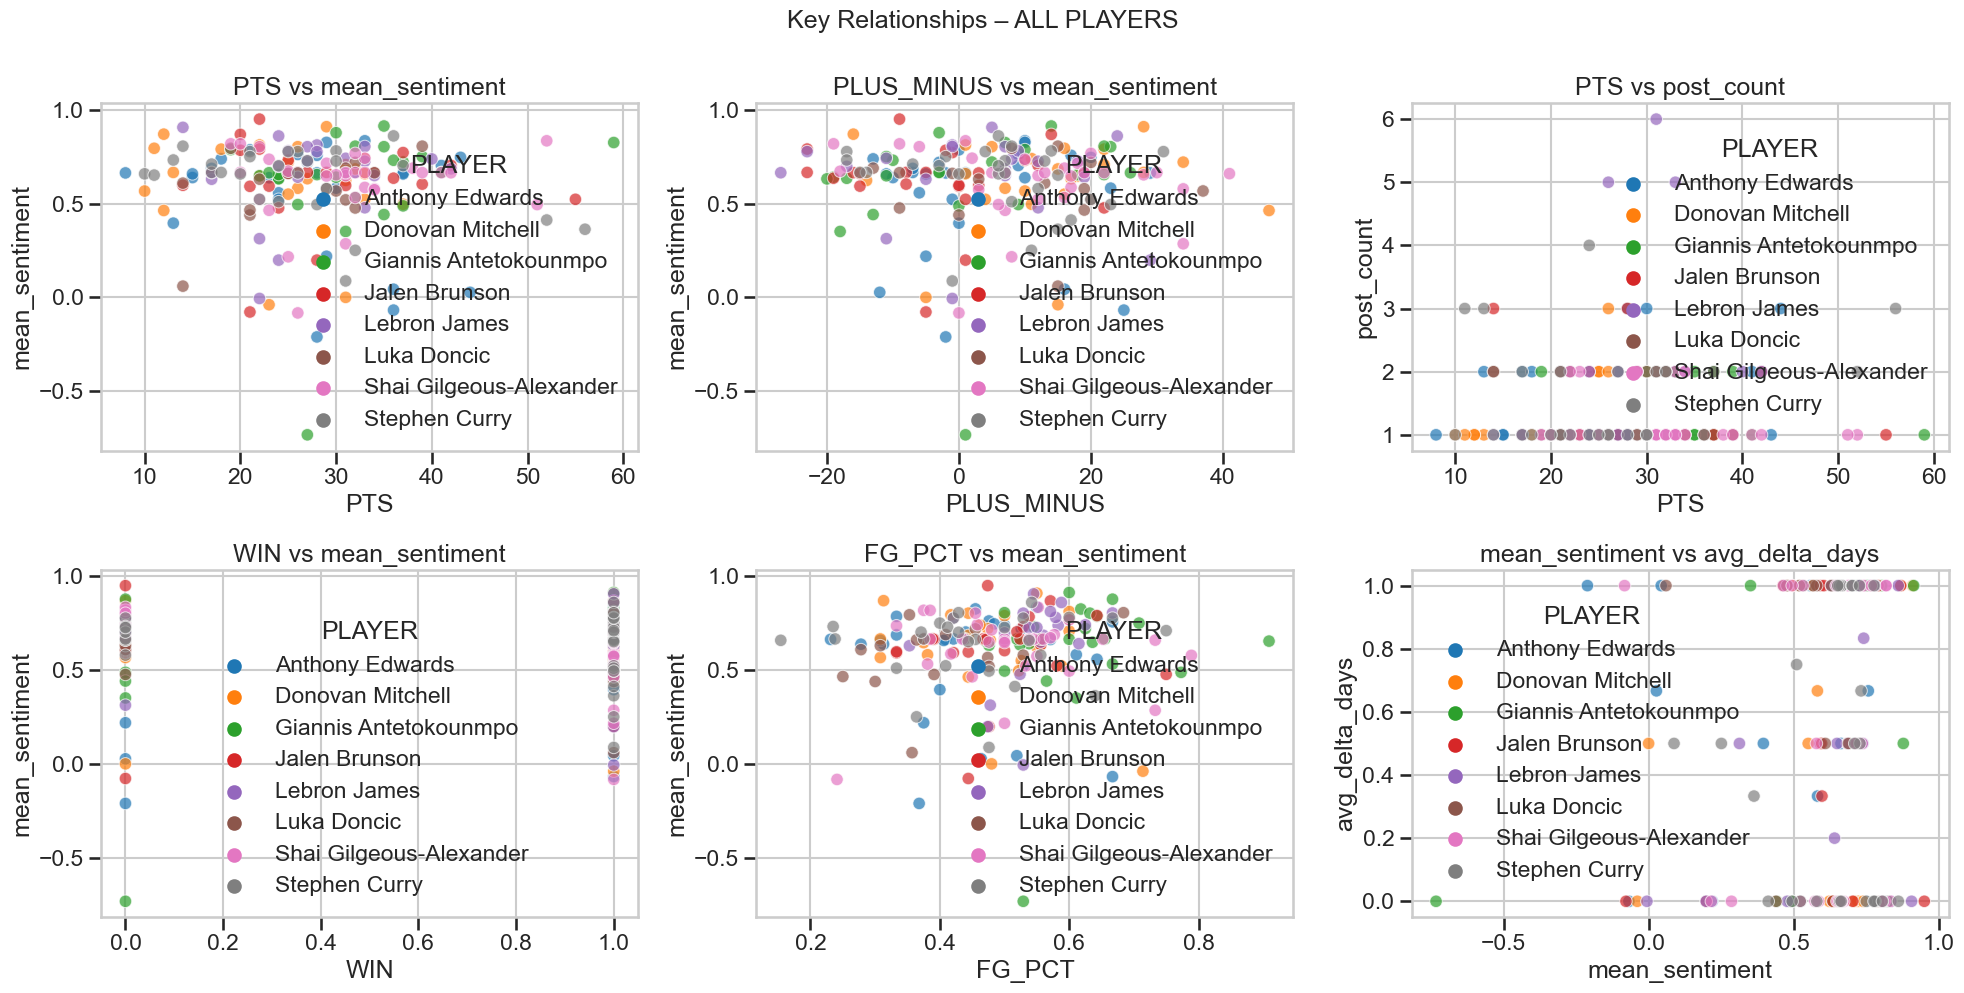


--- MEAN VALUES (ALL PLAYERS) ---
                overall_mean
AST                    6.264
FG_PCT                 0.495
PLUS_MINUS             5.378
PTS                   27.891
REB                    6.218
avg_delta_days         0.484
mean_sentiment         0.611
neg_share              0.057
pos_share              0.943
post_count             1.435


🏁 All Players Processed! 🏁


In [6]:
# ============================================================
# 5. COMBINED GRAPHS ACROSS ALL PLAYERS
#    (run once, after the per‑player loop finishes)
# ============================================================

print("\n\n🔗  BUILDING COMBINED DATASET FOR ALL PLAYERS ------------------")
combined_frames = []
for p_info in player_files_info:
    df_tmp = load_and_preprocess_data(p_info["file_path"], p_info["display_name"])
    if df_tmp is not None and not df_tmp.empty:
        df_tmp["PLAYER"] = p_info["display_name"]   # keep identity for plotting
        combined_frames.append(df_tmp)

if not combined_frames:
    print("❌ No player data available for combined analysis.")
else:
    df_all = pd.concat(combined_frames, ignore_index=True)
    print(f"Combined rows across players: {len(df_all)}")

    # ---------- Feature sets (reuse originals) -----------------
    perf_cols  = ['PTS', 'AST', 'REB', 'PLUS_MINUS', 'FG_PCT']
    senti_cols = ['mean_sentiment', 'pos_share',
                  'neg_share' if 'neg_share' in df_all.columns else 'min_sentiment',
                  'post_count', 'avg_delta_days']

    key_pairs  = [('PTS', 'mean_sentiment'),
                  ('PLUS_MINUS', 'mean_sentiment'),
                  ('PTS', 'post_count'),
                  ('WIN', 'mean_sentiment') if 'WIN' in df_all.columns else None,
                  ('FG_PCT', 'mean_sentiment'),
                  ('mean_sentiment', 'avg_delta_days')]
    key_pairs = [p for p in key_pairs if p is not None]

    # ---------- 5.1 Univariate histograms ----------------------
    print("\n--- COMBINED UNIVARIATE DISTRIBUTIONS ---")
    plt.figure(figsize=(18, 10))
    plot_idx = 1
    for col_group in [perf_cols, senti_cols]:
        for col in col_group:
            if col in df_all.columns and not df_all[col].isnull().all():
                plt.subplot(2, max(len(perf_cols), len(senti_cols)), plot_idx)
                sns.histplot(df_all[col].dropna(), kde=True, bins=20)
                plt.title(f'Distribution of {col}')
                plot_idx += 1
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle('Univariate Distributions – ALL PLAYERS', y=1.00, fontsize=18)
    plt.show()

    # ---------- 5.2 Correlation matrix -------------------------
    print("\n--- COMBINED CORRELATION MATRIX ---")
    numeric_cols = [c for c in perf_cols + senti_cols
                    if c in df_all.columns and pd.api.types.is_numeric_dtype(df_all[c])]
    df_corr_all = df_all[numeric_cols].copy()
    df_corr_all = df_corr_all.apply(pd.to_numeric, errors='coerce')
    df_corr_all.dropna(how='all', axis=0, inplace=True)
    if len(df_corr_all) > 1:
        corr_mat = df_corr_all.corr()
        plt.figure(figsize=(14, 12))
        sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f",
                    linewidths=.5, annot_kws={"size": 7})
        plt.title('Correlation Matrix – ALL PLAYERS', fontsize=16)
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.yticks(rotation=0, fontsize=8)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Not enough data for combined correlation matrix.")

    # ---------- 5.3 Key bivariate scatter plots ---------------
    print("\n--- COMBINED BIVARIATE RELATIONSHIPS ---")
    plt.figure(figsize=(20, 10))
    plot_idx = 1
    for x_col, y_col in key_pairs:
        if x_col in df_all.columns and y_col in df_all.columns:
            plt.subplot(2, 3, plot_idx)
            sns.scatterplot(data=df_all, x=x_col, y=y_col, hue='PLAYER', alpha=0.7)
            plt.title(f'{x_col} vs {y_col}')
            plot_idx += 1
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle('Key Relationships – ALL PLAYERS', y=1.00, fontsize=18)
    plt.show()

    # ---------- 5.4 Combined means table -----------------------
    print("\n--- MEAN VALUES (ALL PLAYERS) ---")
    mean_table_all = (
        df_all[numeric_cols]
        .mean().round(3)
        .to_frame(name='overall_mean')
        .sort_index()
    )
    print(mean_table_all)

print("\n\n🏁 All Players Processed! 🏁")